In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [3]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [4]:
df.sort_values('Date',inplace=True)

In [5]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [6]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [7]:
SaudiـElectricity = df[df['Company Name']== 'Saudi Electricity Co.']

In [8]:
SaudiـElectricity_for_model = SaudiـElectricity[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [9]:
SaudiـElectricity_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
317526,2009-01-03,9.30,9.45,9.25,9.35,0.10,1.08
317528,2009-01-04,9.35,9.40,9.30,9.40,0.05,0.53
317529,2009-01-05,9.40,9.55,9.40,9.45,0.05,0.53
317530,2009-01-06,9.50,9.60,9.45,9.55,0.10,1.05


In [10]:
SaudiـElectricity_for_model.reset_index(inplace=True)

In [11]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(SaudiـElectricity_for_model["Date"][-(227):])[0]

In [12]:
split_date

Timestamp('2019-01-01 00:00:00')

In [13]:
SaudiـElectricity_for_arima = SaudiـElectricity_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [14]:
SaudiـElectricity_for_arima.set_index('Date',inplace=True)

In [15]:
training_set, test_set = SaudiـElectricity_for_model[SaudiـElectricity_for_model['Date'] < split_date], SaudiـElectricity_for_model[SaudiـElectricity_for_model['Date'] >= split_date]


In [16]:
training_set.shape

(2495, 8)

In [17]:
test_set.shape

(227, 8)

In [18]:
test_set.set_index('Date',inplace=True)

In [19]:
training_set.set_index('Date',inplace=True)

In [20]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [21]:
training = training_set.values

In [22]:
testing = test_set.values

## LSTM

## Window length

In [23]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [24]:
LSTM_test_inputs.shape

(222, 5, 6)

In [25]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [26]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [27]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [28]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 624us/step - loss: 8.0969 - val_loss: 6.2447
Epoch 2/120
1992/1992 [==============================] - 1s 324us/step - loss: 2.4006 - val_loss: 7.3593
Epoch 3/120
1992/1992 [==============================] - 1s 305us/step - loss: 2.0212 - val_loss: 6.9705
Epoch 4/120
1992/1992 [==============================] - 1s 343us/step - loss: 1.9196 - val_loss: 6.9117
Epoch 5/120
1992/1992 [==============================] - 1s 350us/step - loss: 1.7910 - val_loss: 6.1929
Epoch 6/120
1992/1992 [==============================] - 1s 273us/step - loss: 1.5823 - val_loss: 5.5459
Epoch 7/120
1992/1992 [==============================] - 1s 299us/step - loss: 1.2728 - val_loss: 4.6378
Epoch 8/120
1992/1992 [==============================] - 1s 280us/step - loss: 0.8242 - val_loss: 3.4635
Epoch 9/120
1992/1992 [==============================] - 1s 268us/step - loss: 0.4519 - val_loss: 2.4403
Epoch 10

Epoch 78/120
1992/1992 [==============================] - 1s 291us/step - loss: 0.2645 - val_loss: 0.5248
Epoch 79/120
1992/1992 [==============================] - 1s 283us/step - loss: 0.2770 - val_loss: 0.5158
Epoch 80/120
1992/1992 [==============================] - 1s 285us/step - loss: 0.2776 - val_loss: 0.6210
Epoch 81/120
1992/1992 [==============================] - 1s 278us/step - loss: 0.2771 - val_loss: 0.5985
Epoch 82/120
1992/1992 [==============================] - 1s 297us/step - loss: 0.2753 - val_loss: 0.6172
Epoch 83/120
1992/1992 [==============================] - 1s 285us/step - loss: 0.2712 - val_loss: 0.6231
Epoch 84/120
1992/1992 [==============================] - 1s 343us/step - loss: 0.2774 - val_loss: 0.5238
Epoch 85/120
1992/1992 [==============================] - 1s 370us/step - loss: 0.2656 - val_loss: 0.4910
Epoch 86/120
1992/1992 [==============================] - 1s 329us/step - loss: 0.2790 - val_loss: 0.5363
Epoch 87/120
1992/1992 [======================

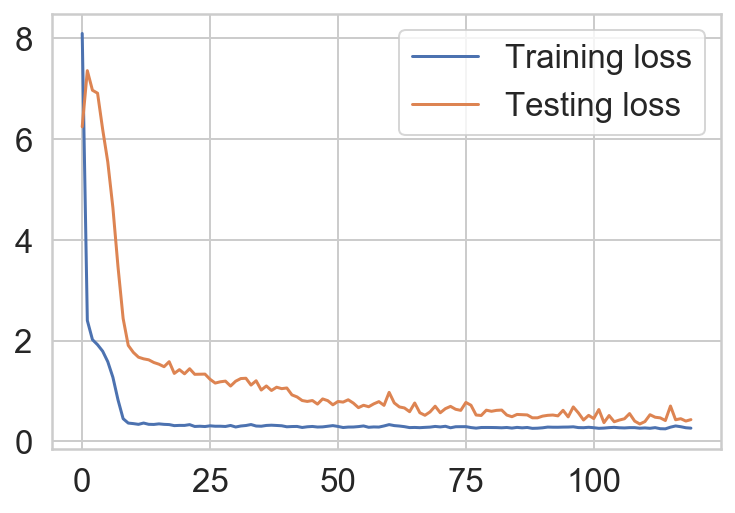

In [29]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [30]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [31]:
y = SaudiـElectricity_for_arima['Close'].resample('MS').mean()

In [32]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [33]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1097.4600200635255
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:892.0336353356097
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:755.0684227035193
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:624.4558421824612
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:550.8401563792837
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:495.57649378322884
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:661.7876692395513
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:529.7544634132882
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:438.31946430659536
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:629.757578867376
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:574.6947522652865
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:522.1388771970168
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:556.8577937577036
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:550.7317005478834
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:497.5713007277235
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:558.8459176941066
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:518.777042586303
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:448.4606548753783
ARIMA(0, 

ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:255.70687045515712
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:357.27028695589627
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:295.35031738914
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:256.85078030419277
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:268.6983959429262
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:269.9962631857204
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:267.2856003437087
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:264.6798467586208
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:263.8025304439517
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:255.77340782854748
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:287.85602183530114
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:267.01432552016297
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:260.00435645540495
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:372.02873439439793
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:347.0059117634531
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:310.51876329429587
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:435.6447256612342
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:331.3798789409668
ARI

ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:301.2263323704039
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:268.0834865317612
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:386.271430501941
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:286.02463190929996
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:258.1952868522419
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:473.9334355723307
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:338.06070626261754
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:255.56413218554965
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:300.1142304378175
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:297.44221700167475
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:272.67240121147097
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:298.2039827412422
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:282.120918544954
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:257.60001706299585
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:352.9745511692994
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:296.36264683300874
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:266.2001993433201
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:270.6981352449894
ARIMA

ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:355.08431094407695
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:301.72084934955757
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:262.7581220548184
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:270.925328838842
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:272.57900862909577
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:271.74434085183816
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:264.6564110710823
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:265.18808264984574
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:261.8328102988711
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:286.4430258003222
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:268.0394399822143
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:265.6019321860024
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:318.94759185519433
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:294.3673213579787
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:266.5984938323239
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:390.16952175780597
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:290.6739045535238
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:261.1923659125339
ARIM

ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:268.10867004741976
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:391.5798512674361
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:287.87622655553406
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:261.9212172436012
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:475.3214393508142
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:342.7764156223641
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:262.27034080106444
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:297.3084494368905
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:298.5838678649504
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:270.0736657976762
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:299.6538054648447
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:285.96806136997975
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:260.97254588382646
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:350.3374944678519
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:301.25793848301646
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:262.52971905336346
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:268.08474450756074
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:269.5766817381092
AR

In [34]:
#ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:390.88788508639425

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2181      0.109      1.995      0.046       0.004       0.432
ma.L2          0.3023      0.128      2.357      0.018       0.051       0.554
ma.S.L12      -1.8498   1836.676     -0.001      0.999   -3601.669    3597.969
ma.S.L24       1.0000   1985.769      0.001      1.000   -3891.035    3893.035
sigma2         0.9132   1813.555      0.001      1.000   -3553.589    3555.415


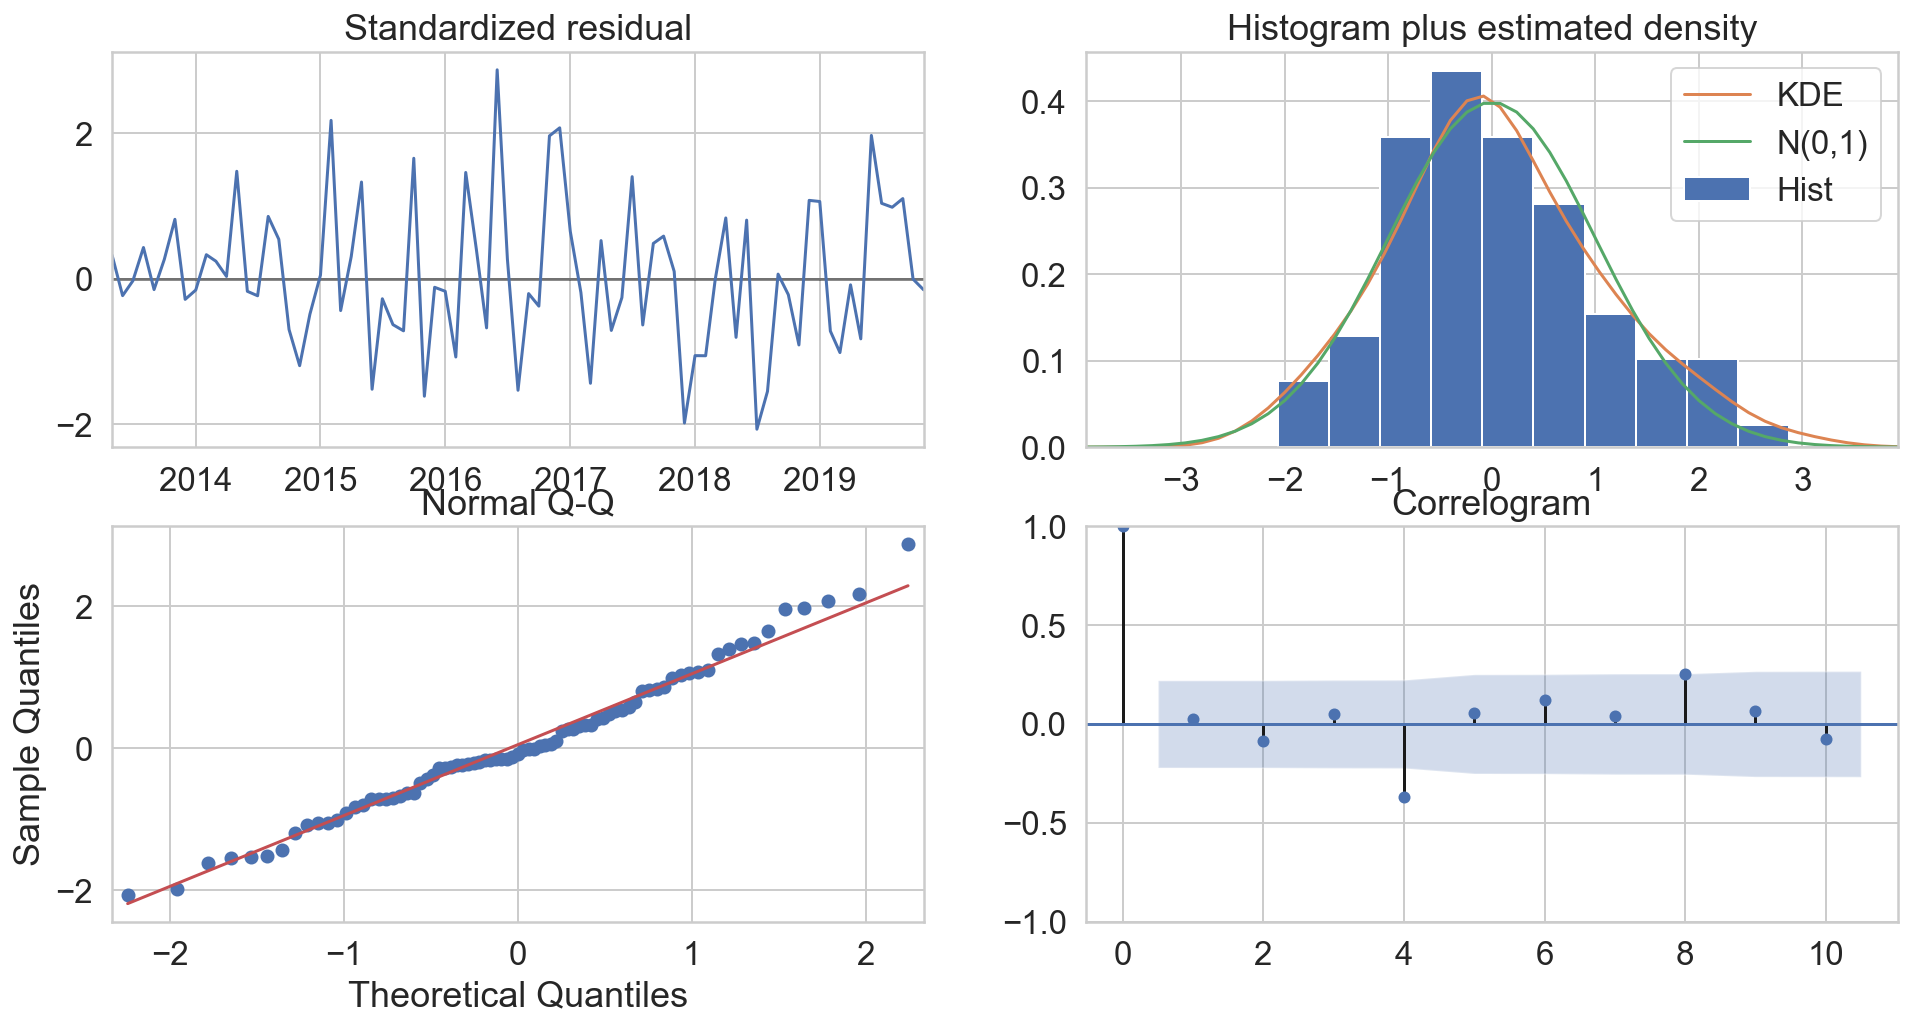

In [35]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

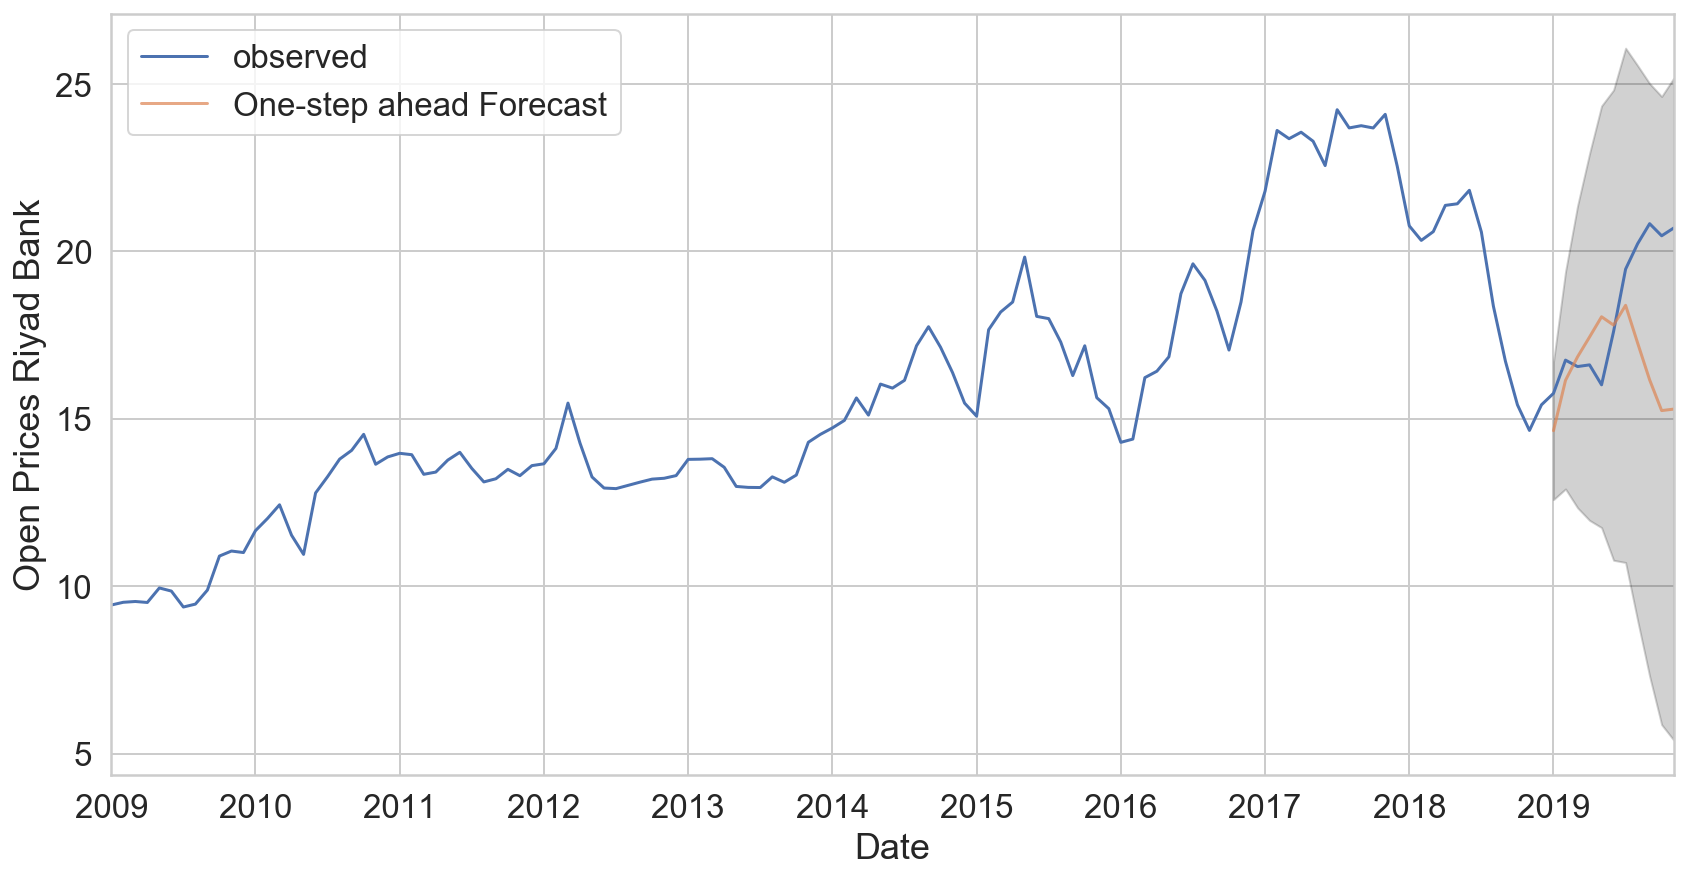

In [36]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices Riyad Bank')
plt.legend()
plt.show()

In [37]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 8.61


In [38]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2.93


## Producing and visualizing forecasts

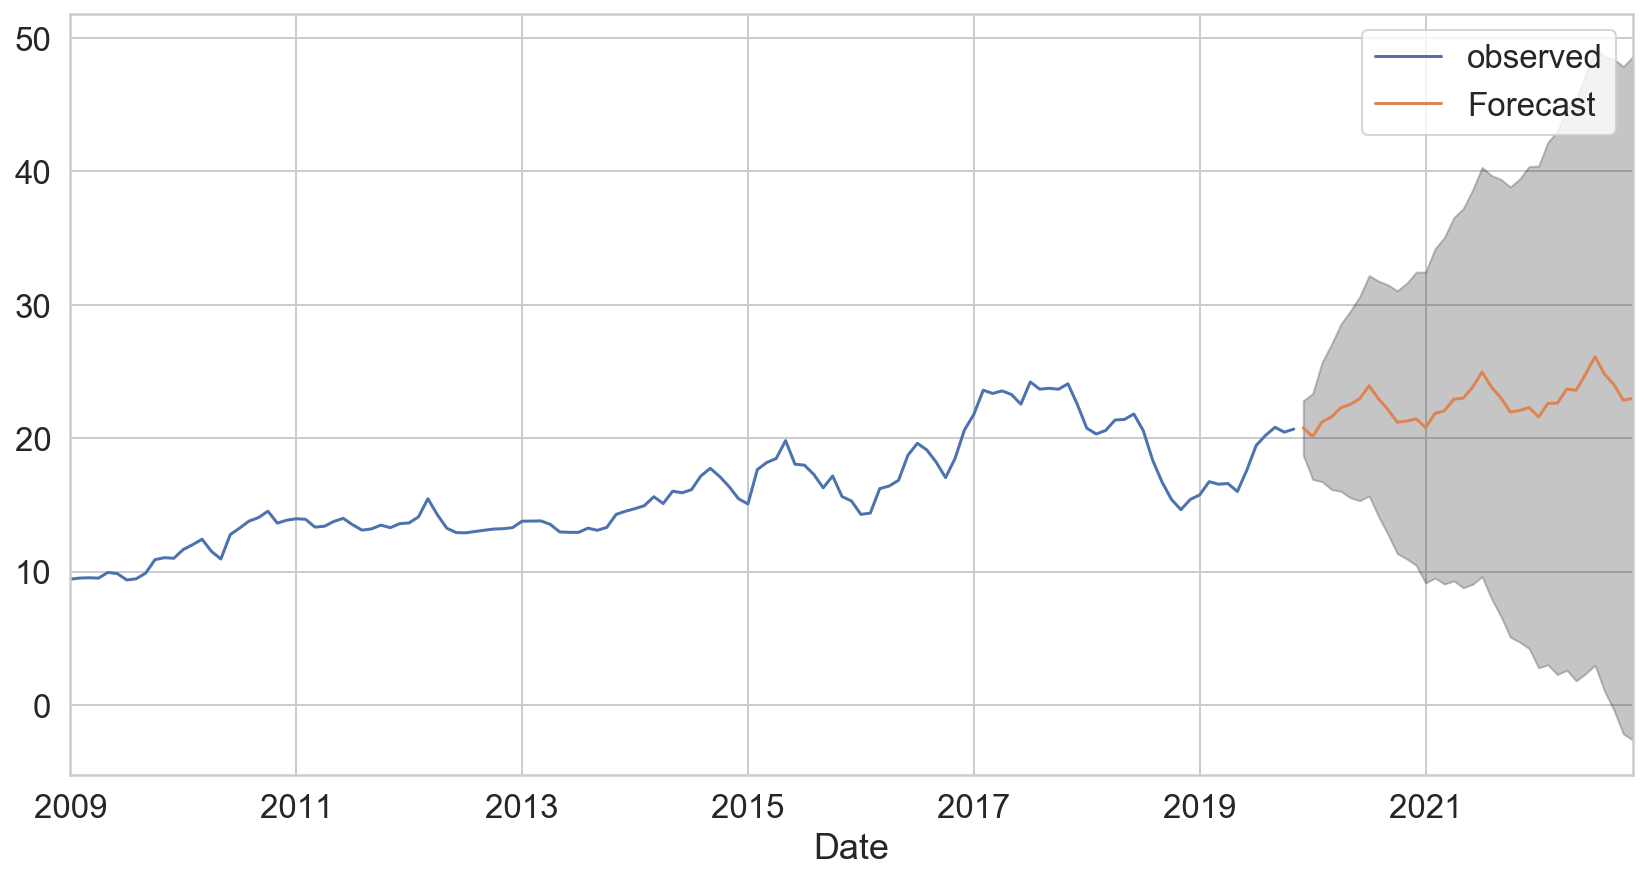

In [39]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [40]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [42]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [43]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [44]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

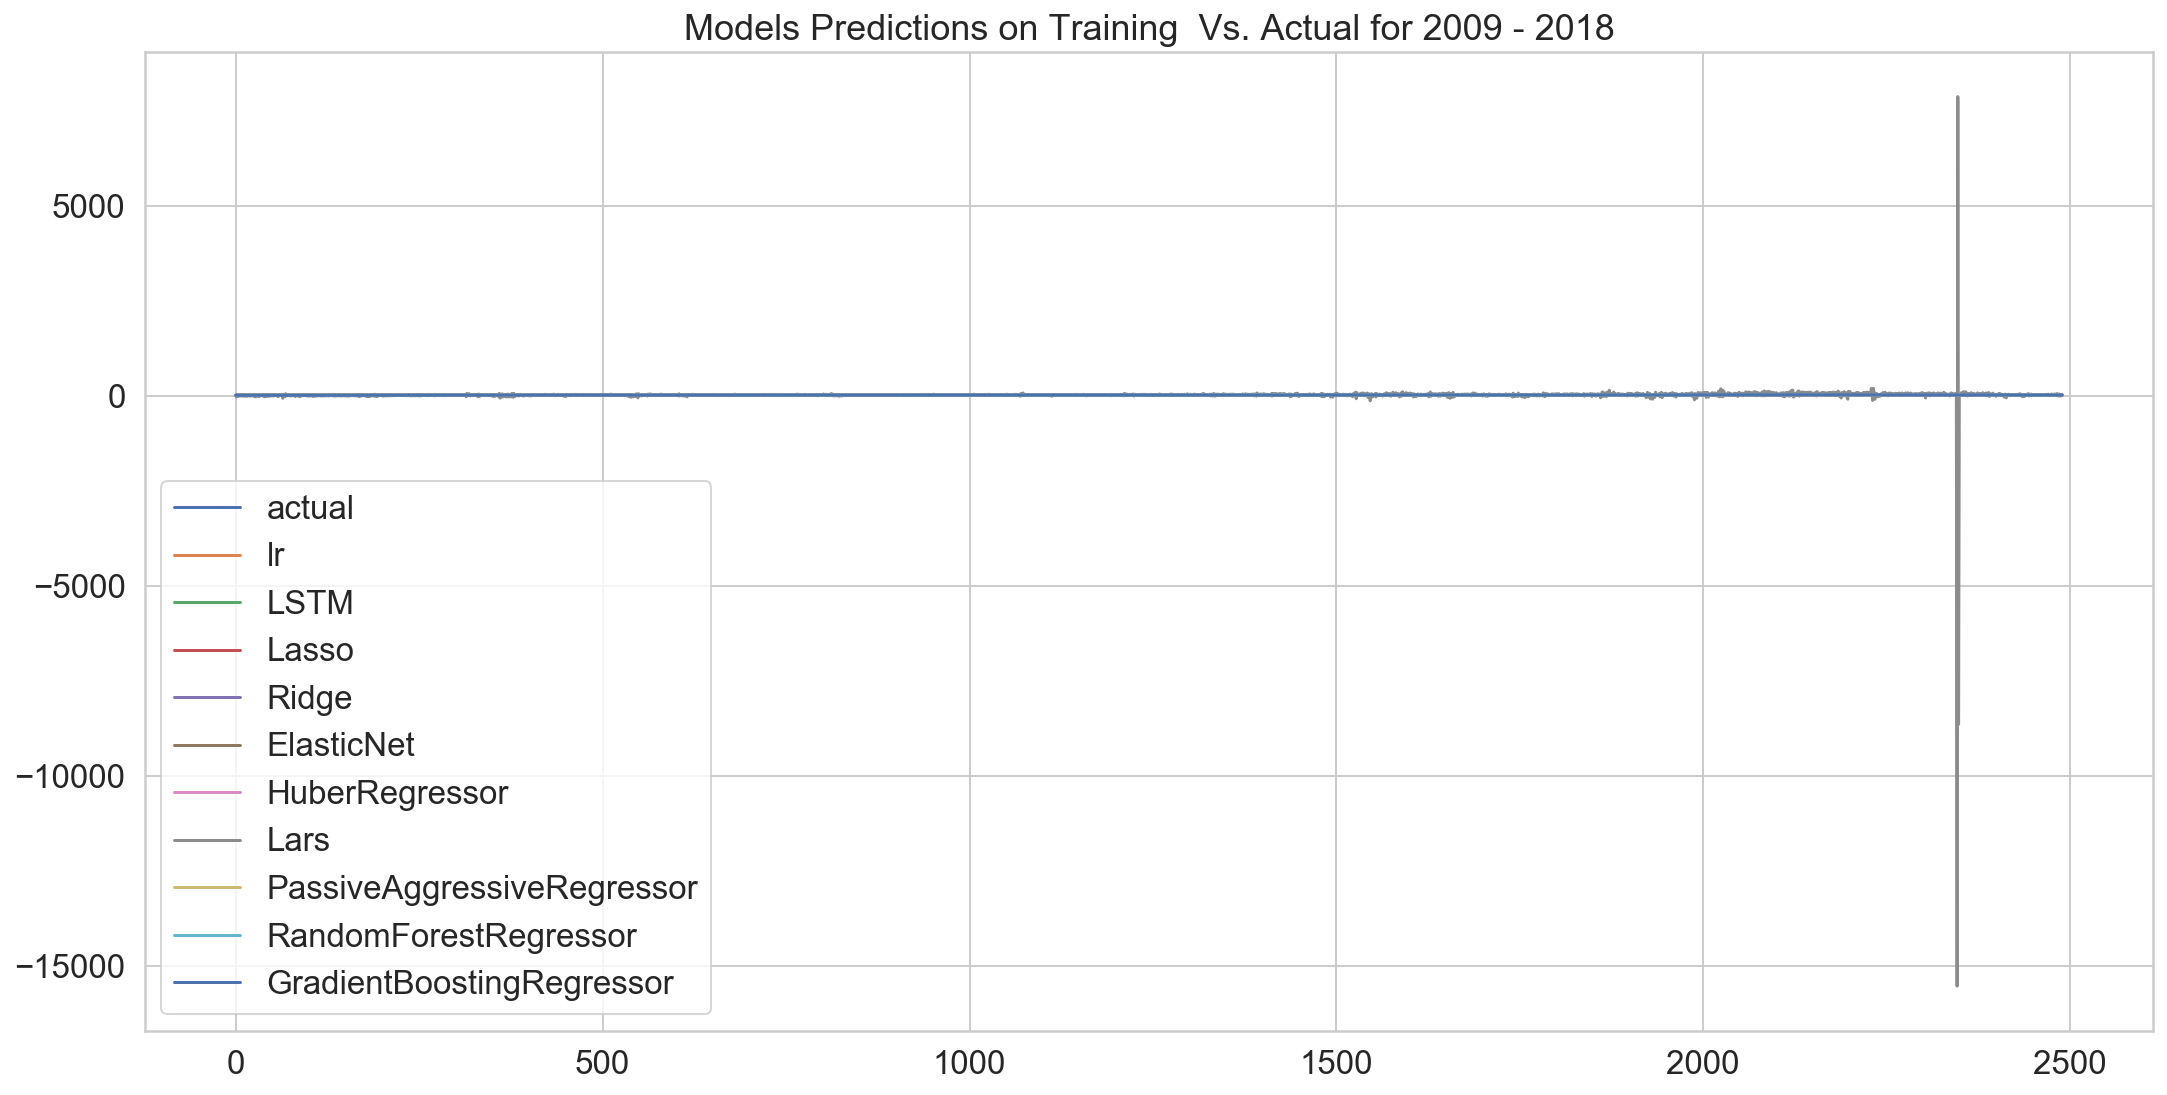

In [45]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

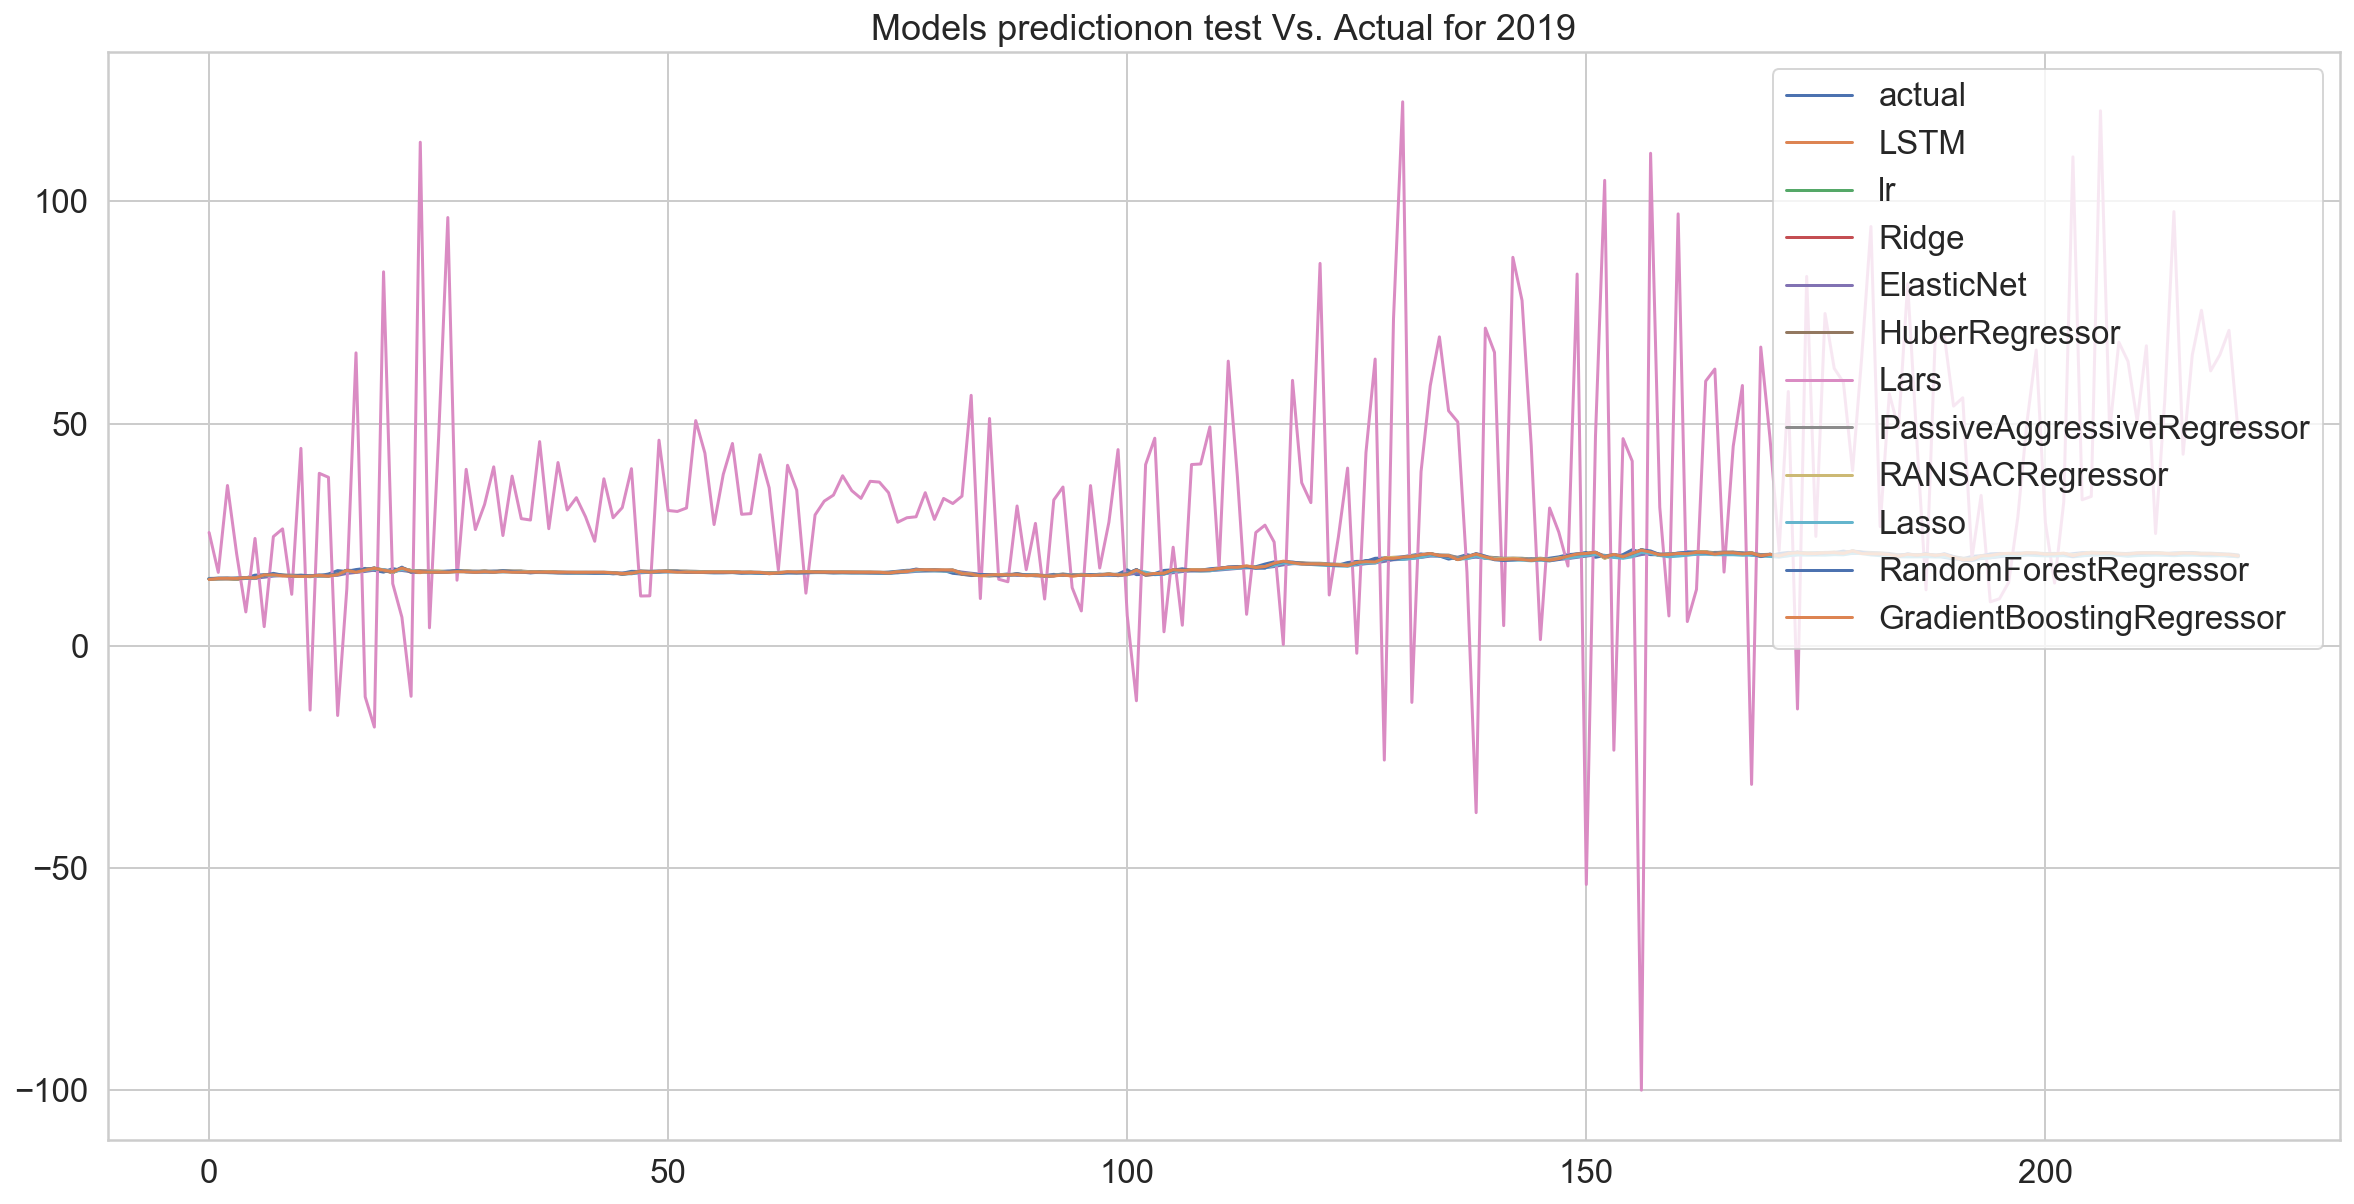

In [46]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [47]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [48]:
predictions_test.head()

,Actual,Lr,Lasso,Ridge,ElasticNet,PassiveAggressiveRegressor,HuberRegressor,Lars,RANSACRegressor,LSTM,RandomForestRegressor,GradientBoostingRegressor
0,15.10,15.028161,15.112663,15.026639,15.150802,15.128711,15.037308,25.481664,15.035424,14.951367,15.058,14.937178
1,15.12,15.108967,15.068592,15.107958,15.113613,15.196675,15.100029,16.505424,15.115317,15.013678,15.198,15.153192
2,15.06,15.118990,15.111789,15.120881,15.133956,15.223964,15.134946,36.067642,15.112028,15.041377,15.208,15.170454
3,15.26,15.033938,15.081434,15.034463,15.112005,15.150101,15.043214,20.682916,15.039163,14.958511,15.134,15.145006
4,15.24,15.253680,15.215698,15.253253,15.147322,15.355174,15.238291,7.605224,15.244575,15.148746,15.247,15.302060


## Validating our model

In [49]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [50]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [51]:
df_new.sort_values('Date',inplace=True)

In [52]:
df_new.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
2121,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-03,17.06,17.06,16.78,16.90,-0.26,-1.52,147529,2494172.96,325
2123,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-04,17.38,17.38,17.18,17.18,-0.20,-1.15,142735,2465908.84,205
2133,Insurance,8290,Solidarity Saudi Takaful Co.,2009-01-05,10.32,10.36,10.30,10.34,-0.02,-0.19,47405,489919.30,106
2118,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-06,17.42,17.54,17.40,17.50,0.00,0.00,117410,2049337.42,222


In [53]:
SaudiـElectricity_2_weeks = df_new[df_new['Company Name']== 'Saudi Electricity Co.']

In [54]:
SaudiـElectricity_2_weeks

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
1635,Utilities,5110,Saudi Electricity Co.,2012-03-20,20.20,20.38,20.14,20.38,0.10,0.49,334847,6794941.28,397
1636,Utilities,5110,Saudi Electricity Co.,2012-03-31,20.14,20.14,20.00,20.04,0.04,0.20,285658,5725106.00,372
1637,Utilities,5110,Saudi Electricity Co.,2012-04-01,20.32,20.54,20.16,20.16,-0.32,-1.56,818872,16665955.72,551
1634,Utilities,5110,Saudi Electricity Co.,2012-04-04,20.38,20.38,20.12,20.28,-0.22,-1.07,473747,9583625.92,599
1639,Utilities,5110,Saudi Electricity Co.,2012-04-15,20.16,20.50,20.08,20.08,-0.12,-0.59,672188,13593764.06,828
1640,Utilities,5110,Saudi Electricity Co.,2012-04-16,20.14,20.18,20.00,20.00,-0.08,-0.40,1372362,27504560.54,1233
1641,Utilities,5110,Saudi Electricity Co.,2012-04-17,20.20,20.52,20.20,20.48,0.10,0.49,280753,5744613.80,286
1638,Utilities,5110,Saudi Electricity Co.,2012-04-22,20.30,20.38,20.20,20.20,0.04,0.20,408576,8280752.16,598
1633,Utilities,5110,Saudi Electricity Co.,2013-07-11,19.96,20.58,19.96,20.50,0.54,2.71,923177,18815958.28,1097
1631,Utilities,5110,Saudi Electricity Co.,2013-07-15,20.16,20.28,20.08,20.28,0.00,0.00,120690,2432938.84,193


In [55]:
SaudiـElectricity2w_for_model = SaudiـElectricity_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [56]:
SaudiـElectricity2w_for_model

,Date,Open,High,Low,Close,Change,% Change
1635,2012-03-20,20.20,20.38,20.14,20.38,0.10,0.49
1636,2012-03-31,20.14,20.14,20.00,20.04,0.04,0.20
1637,2012-04-01,20.32,20.54,20.16,20.16,-0.32,-1.56
1634,2012-04-04,20.38,20.38,20.12,20.28,-0.22,-1.07
1639,2012-04-15,20.16,20.50,20.08,20.08,-0.12,-0.59
1640,2012-04-16,20.14,20.18,20.00,20.00,-0.08,-0.40
1641,2012-04-17,20.20,20.52,20.20,20.48,0.10,0.49
1638,2012-04-22,20.30,20.38,20.20,20.20,0.04,0.20
1633,2013-07-11,19.96,20.58,19.96,20.50,0.54,2.71
1631,2013-07-15,20.16,20.28,20.08,20.28,0.00,0.00


In [57]:
SaudiـElectricity2w_for_model.reset_index(inplace=True)

In [58]:
asm = SaudiـElectricity_for_model[-6:]

In [59]:
asm

,index,Date,Open,High,Low,Close,Change,% Change
2716,315431,2019-11-21,20.72,20.84,20.72,20.74,-0.16,-0.77
2717,315432,2019-11-24,20.74,20.74,20.70,20.70,-0.04,-0.19
2718,315433,2019-11-25,20.70,20.88,20.54,20.54,-0.16,-0.77
2719,315434,2019-11-26,20.74,20.82,20.34,20.44,-0.10,-0.49
2720,315435,2019-11-27,20.44,20.62,20.16,20.20,-0.24,-1.17
2721,315436,2019-11-28,20.28,20.48,19.84,20.28,0.08,0.40


In [60]:
SaudiـElectricity2w_for_model

,index,Date,Open,High,Low,Close,Change,% Change
0,1635,2012-03-20,20.20,20.38,20.14,20.38,0.10,0.49
1,1636,2012-03-31,20.14,20.14,20.00,20.04,0.04,0.20
2,1637,2012-04-01,20.32,20.54,20.16,20.16,-0.32,-1.56
3,1634,2012-04-04,20.38,20.38,20.12,20.28,-0.22,-1.07
4,1639,2012-04-15,20.16,20.50,20.08,20.08,-0.12,-0.59
5,1640,2012-04-16,20.14,20.18,20.00,20.00,-0.08,-0.40
6,1641,2012-04-17,20.20,20.52,20.20,20.48,0.10,0.49
7,1638,2012-04-22,20.30,20.38,20.20,20.20,0.04,0.20
8,1633,2013-07-11,19.96,20.58,19.96,20.50,0.54,2.71
9,1631,2013-07-15,20.16,20.28,20.08,20.28,0.00,0.00


In [61]:
abr = asm.merge(SaudiـElectricity2w_for_model, how='outer')

In [62]:
abr.set_index('Date',inplace=True)

In [63]:
abr.pop('index')

Date
2019-11-21    315431
2019-11-24    315432
2019-11-25    315433
2019-11-26    315434
2019-11-27    315435
2019-11-28    315436
2012-03-20      1635
2012-03-31      1636
2012-04-01      1637
2012-04-04      1634
2012-04-15      1639
2012-04-16      1640
2012-04-17      1641
2012-04-22      1638
2013-07-11      1633
2013-07-15      1631
2013-07-16      1632
Name: index, dtype: int64

In [64]:
abr

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-11-21,20.72,20.84,20.72,20.74,-0.16,-0.77
2019-11-24,20.74,20.74,20.70,20.70,-0.04,-0.19
2019-11-25,20.70,20.88,20.54,20.54,-0.16,-0.77
2019-11-26,20.74,20.82,20.34,20.44,-0.10,-0.49
2019-11-27,20.44,20.62,20.16,20.20,-0.24,-1.17
2019-11-28,20.28,20.48,19.84,20.28,0.08,0.40
2012-03-20,20.20,20.38,20.14,20.38,0.10,0.49
2012-03-31,20.14,20.14,20.00,20.04,0.04,0.20
2012-04-01,20.32,20.54,20.16,20.16,-0.32,-1.56


In [65]:
abr2=abr[1:].values

In [66]:
abr2

array([[20.74, 20.74, 20.7 , 20.7 , -0.04, -0.19],
       [20.7 , 20.88, 20.54, 20.54, -0.16, -0.77],
       [20.74, 20.82, 20.34, 20.44, -0.1 , -0.49],
       [20.44, 20.62, 20.16, 20.2 , -0.24, -1.17],
       [20.28, 20.48, 19.84, 20.28,  0.08,  0.4 ],
       [20.2 , 20.38, 20.14, 20.38,  0.1 ,  0.49],
       [20.14, 20.14, 20.  , 20.04,  0.04,  0.2 ],
       [20.32, 20.54, 20.16, 20.16, -0.32, -1.56],
       [20.38, 20.38, 20.12, 20.28, -0.22, -1.07],
       [20.16, 20.5 , 20.08, 20.08, -0.12, -0.59],
       [20.14, 20.18, 20.  , 20.  , -0.08, -0.4 ],
       [20.2 , 20.52, 20.2 , 20.48,  0.1 ,  0.49],
       [20.3 , 20.38, 20.2 , 20.2 ,  0.04,  0.2 ],
       [19.96, 20.58, 19.96, 20.5 ,  0.54,  2.71],
       [20.16, 20.28, 20.08, 20.28,  0.  ,  0.  ],
       [20.1 , 20.2 , 19.92, 19.96, -0.32, -1.58]])

In [67]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [68]:
X_valid

array([[[20.74, 20.74, 20.7 , 20.7 , -0.04, -0.19],
        [20.7 , 20.88, 20.54, 20.54, -0.16, -0.77],
        [20.74, 20.82, 20.34, 20.44, -0.1 , -0.49],
        [20.44, 20.62, 20.16, 20.2 , -0.24, -1.17],
        [20.28, 20.48, 19.84, 20.28,  0.08,  0.4 ]],

       [[20.7 , 20.88, 20.54, 20.54, -0.16, -0.77],
        [20.74, 20.82, 20.34, 20.44, -0.1 , -0.49],
        [20.44, 20.62, 20.16, 20.2 , -0.24, -1.17],
        [20.28, 20.48, 19.84, 20.28,  0.08,  0.4 ],
        [20.2 , 20.38, 20.14, 20.38,  0.1 ,  0.49]],

       [[20.74, 20.82, 20.34, 20.44, -0.1 , -0.49],
        [20.44, 20.62, 20.16, 20.2 , -0.24, -1.17],
        [20.28, 20.48, 19.84, 20.28,  0.08,  0.4 ],
        [20.2 , 20.38, 20.14, 20.38,  0.1 ,  0.49],
        [20.14, 20.14, 20.  , 20.04,  0.04,  0.2 ]],

       [[20.44, 20.62, 20.16, 20.2 , -0.24, -1.17],
        [20.28, 20.48, 19.84, 20.28,  0.08,  0.4 ],
        [20.2 , 20.38, 20.14, 20.38,  0.1 ,  0.49],
        [20.14, 20.14, 20.  , 20.04,  0.04,  0.2 ],
      

In [69]:
X_valid_resaped = X_valid.reshape(11,30)

In [70]:
y_valid

array([20.28, 20.38, 20.04, 20.16, 20.28, 20.08, 20.  , 20.48, 20.2 ,
       20.5 , 20.28, 19.96])

In [71]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

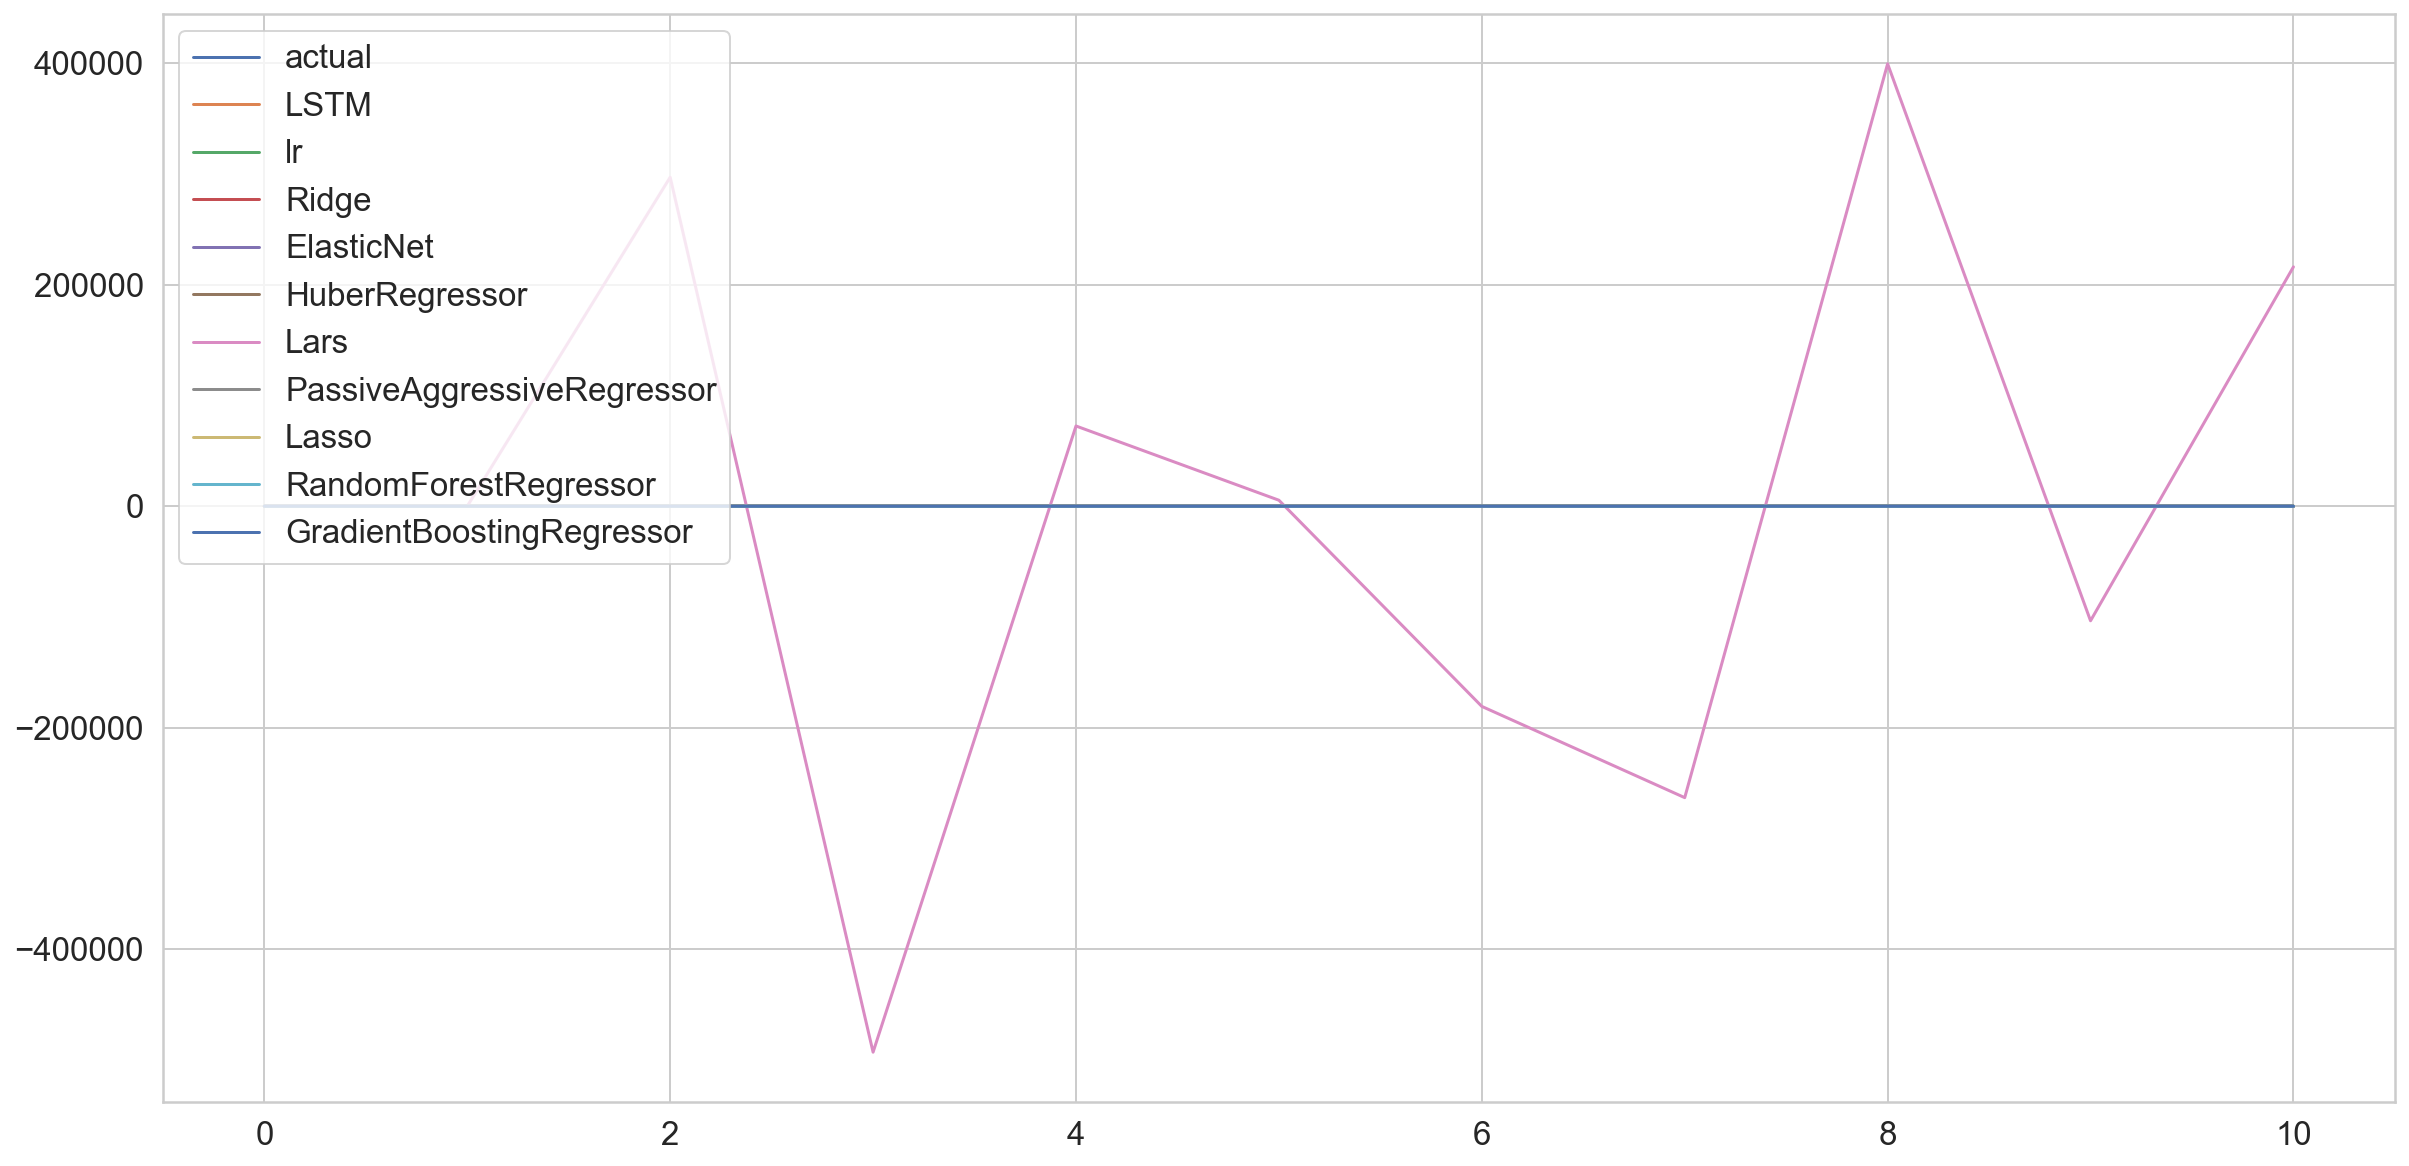

In [72]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [73]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [74]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [75]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [76]:
R2_score_test_LSTM

0.9757102877478981

In [77]:
R2_traininig_score_LSTM

0.9917525791399558

In [78]:
R2_score_valid_LSTM

0.24246843902046333

In [79]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [80]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [81]:
R2_scores

,models,Training_R2,Test_R2,valid_R2
0,LSTM,0.991753,0.975710,2.424684e-01
1,LR,0.995882,0.979246,-9.812653e+02
2,lasso,0.990392,0.959452,-4.505291e+00
3,ridge,0.995876,0.979260,7.064397e-01
4,en,0.991861,0.964781,-1.107314e+00
5,huber,0.995750,0.979041,7.105019e-01
6,lars,-10347.456624,-288.240324,-2.336349e+12
7,pa,0.994597,0.978902,-5.512551e-01
8,gboost,0.997549,0.977527,7.048886e-01
9,rt,0.999126,0.975288,2.434828e-01


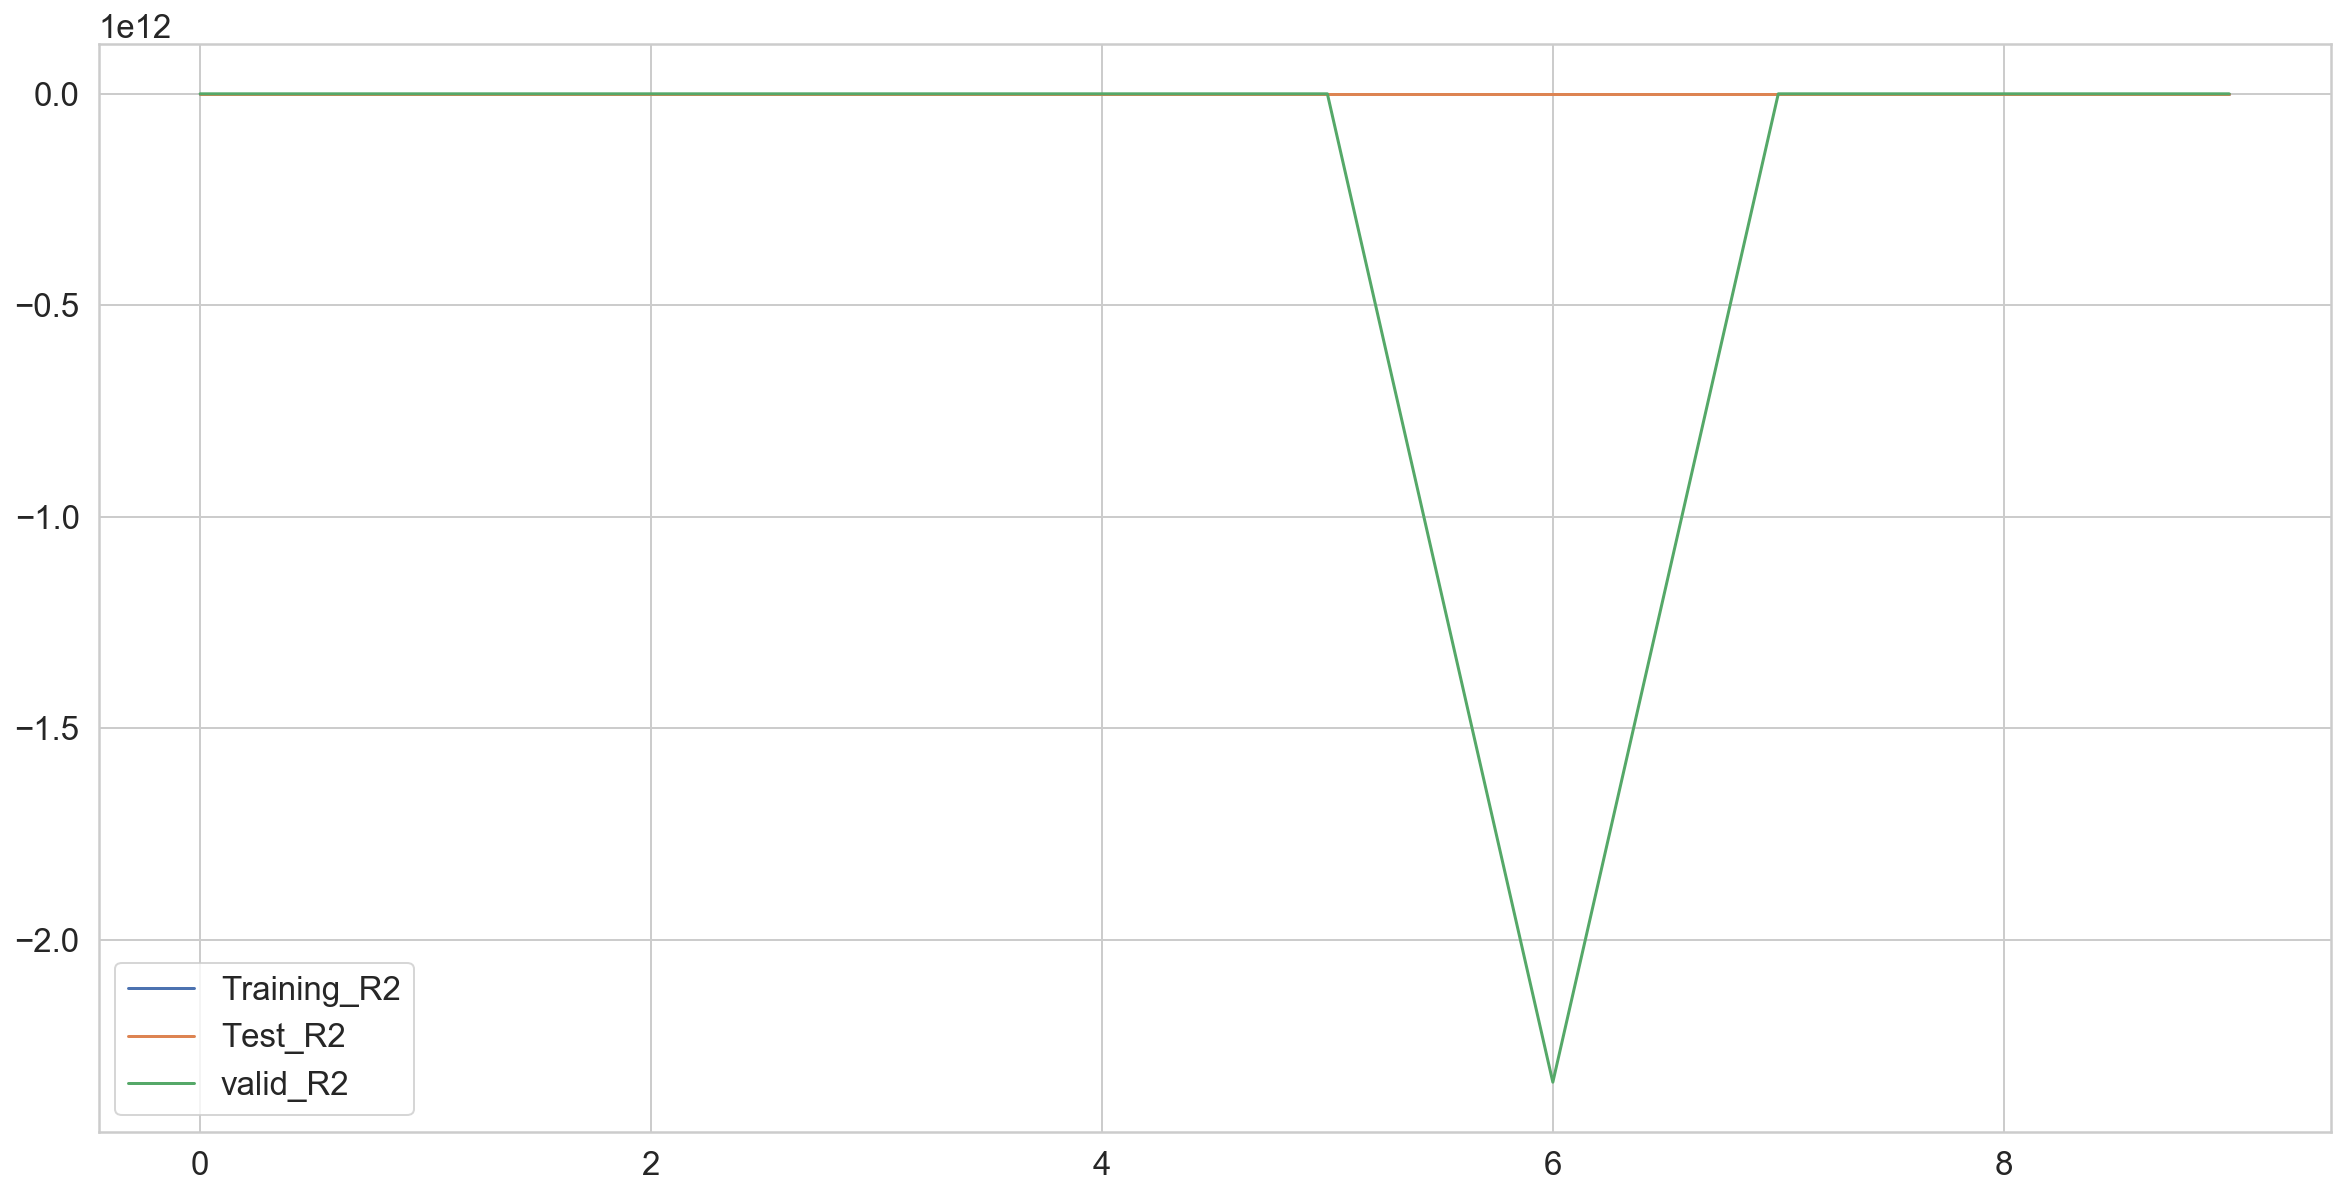

In [82]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()